## 1. Import

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## 2. 데이터 전처리

In [101]:
train = pd.read_csv('./data/train.csv')

# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

pivot.head()

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


## 3. 공행성쌍 탐색
- 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
- 절댓값이 가장 큰 상관계수와 lag를 선택
- |corr| >= corr_threshold이면 A→B 공행성 있다고 판단

In [7]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs = find_comovement_pairs(pivot)
print("탐색된 공행성쌍 수:", len(pairs))
pairs.head()

100it [00:07, 13.82it/s]

탐색된 공행성쌍 수: 1425


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.443984
1,AANGBULD,DEWLVASR,6,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635
3,AANGBULD,EVBVXETX,6,0.436623
4,AANGBULD,FTSVTTSR,3,0.531400


## 4. 회귀 모델 학습
- 시계열 데이터 안에서 '한 달 뒤 총 무역량(value)을 맞추는 문제'로 self-supervised 학습
- 탐색된 모든 공행성쌍 (A,B)에 대해 월 t마다 학습 샘플 생성
- input X:
1) B_t (현재 총 무역량(value))
2) B_{t-1} (직전 달 총 무역량(value))
3) A_{t-lag} (lag 반영된 총 무역량(value))
4) max_corr, best_lag (관계 특성)
- target y:
1) B_{t+1} (다음 달 총 무역량(value))
- 이러한 모든 샘플을 합쳐 LinearRegression 회귀 모델을 학습

In [8]:
def build_training_data(pivot, pairs):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

df_train_model = build_training_data(pivot, pairs)
print('생성된 학습 데이터의 shape :', df_train_model.shape)
df_train_model.head()

생성된 학습 데이터의 shape : (54743, 6)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,target
0,582317.0,539873.0,14276.0,-0.443984,5.0,759980.0
1,759980.0,582317.0,52347.0,-0.443984,5.0,216019.0
2,216019.0,759980.0,53549.0,-0.443984,5.0,537693.0
3,537693.0,216019.0,0.0,-0.443984,5.0,205326.0
4,205326.0,537693.0,26997.0,-0.443984,5.0,169440.0


In [9]:
# 회귀모델 학습
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

reg = LinearRegression()
reg.fit(train_X, train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 5. 회귀 모델 추론 및 제출(submission) 파일 생성
- 탐색된 공행성 쌍에 대해 후행 품목(following_item_id)에 대한 2025년 8월 총 무역량(value) 예측

In [10]:
def predict(pivot, pairs, reg):
    months = pivot.columns.to_list()
    n_months = len(months)

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1
    t_prev = n_months - 2

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = reg.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [11]:
submission = predict(pivot, pairs, reg)
submission.head()

1425it [00:00, 5195.69it/s]


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,360075
1,AANGBULD,DEWLVASR,610115
2,AANGBULD,DNMPSKTB,4999179
3,AANGBULD,EVBVXETX,4904136
4,AANGBULD,FTSVTTSR,387062


In [12]:
submission.to_csv('./baseline_submit.csv', index=False)

### hs4에 따른 value 확인

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import matplotlib
import matplotlib.font_manager as fm

# C:\Windows\Fonts   # ==> OS에 등록되어 있는 모든 폰트 파일들
font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS 폰트 경로

font_prop = fm.FontProperties(fname = font_path) # 폰트경로에 있는 폰트 이름들 뽑아오자.


font_name = font_prop.get_name() # 폰트명

#matplotlib.rc('font', key=value)
matplotlib.rc('font', family=font_name)

# matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화
# -> 아스키코드의 마이너스 사용
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

In [70]:
# 가장 무역량이 많은 hs4 코드 찾기
hs4_group_value = train.groupby('hs4')['value'].max().astype(int).sort_values(ascending=False)
max_value_df = hs4_group_value.reset_index()

max_20_value = max_value_df.head(20)
max_20_value

,hs4,value
0,2814,111041383
1,3824,57701119
2,3102,49185609
3,8501,41757759
4,8505,33404074
5,3815,31699923
6,6211,20896169
7,2833,14373828
8,8479,13424333
9,7207,12041624


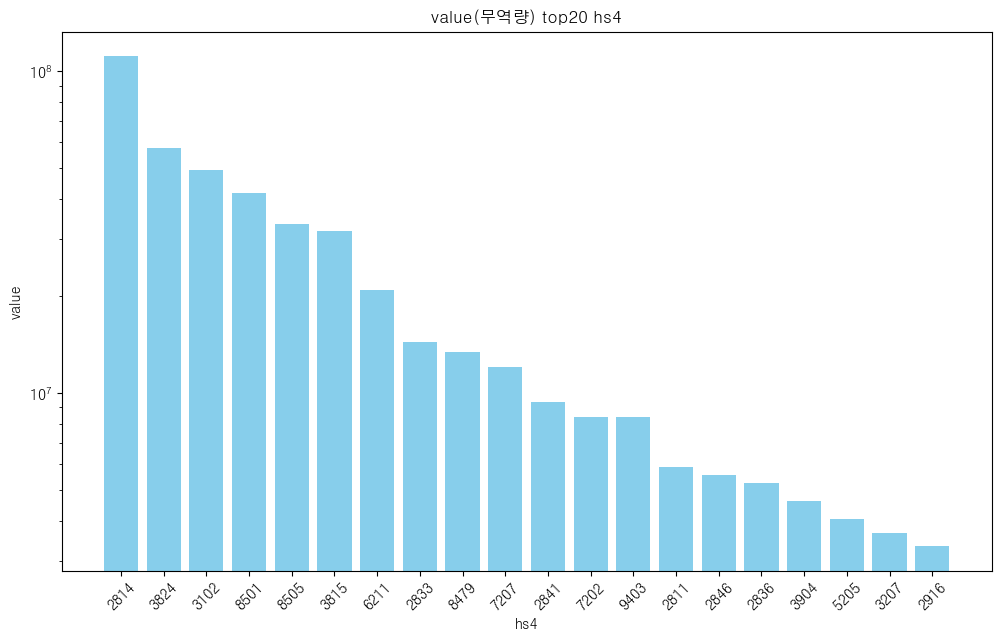

In [79]:
# 시각화
plt.figure(figsize=(12, 7))
plt.bar(max_20_value['hs4'].astype(str), max_20_value['value'], color='skyblue')

plt.xticks(rotation=45)
plt.yscale('log') # 로그로 한 눈에 보기 쉽게 출력

plt.title('value(무역량) top20 hs4')
plt.xlabel('hs4')
plt.ylabel('value')

plt.show()

In [108]:
monthly_data = train.groupby(['year', 'month', 'hs4'])['value'].sum().reset_index()
monthly_data.rename(columns = {'value' : 'total_value'}, inplace=True)
monthly_data.head()

,year,month,hs4,total_value
0,2022,1,1210,471191.0
1,2022,1,2002,267743.0
2,2022,1,2102,242705.0
3,2022,1,2501,108699.0
4,2022,1,2529,1179252.0


In [112]:
# 날짜를 2022-01-01로 합치기
monthly_data['date'] = pd.to_datetime(monthly_data['year'].astype(str) + '-' + monthly_data['month'].astype(str))
monthly_data

,year,month,hs4,total_value,date
0,2022,1,1210,471191.0,2022-01-01
1,2022,1,2002,267743.0,2022-01-01
2,2022,1,2102,242705.0,2022-01-01
3,2022,1,2501,108699.0,2022-01-01
4,2022,1,2529,1179252.0,2022-01-01
...,...,...,...,...,...
2677,2025,7,8527,26863.0,2025-07-01
2678,2025,7,8708,55545.0,2025-07-01
2679,2025,7,8714,138938.0,2025-07-01
2680,2025,7,9022,90375.0,2025-07-01


In [237]:
# 피벗 테이블
pivot_monthly = pd.pivot_table(monthly_data, index='date', columns='hs4', values='total_value')
pivot_monthly

# 5개의 열만
# pivot_monthly.loc[:,pivot_monthly.columns[:5]]

# 전년 대비 수익률
# rtn_data = pivot_monthly.pct_change(periods=12)
# rtn_data # 2022년 이전 데이터는 없으므로 모두 NaN 출력

hs4,1210,2002,2102,2501,2529,2612,2701,2710,2805,2807,...,8461,8467,8479,8501,8505,8527,8708,8714,9022,9403
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,471191.0,267743.0,242705.0,108699.0,1179252.0,NaN,26.0,NaN,1680327.0,34999.0,...,373859.0,1289.0,16488096.0,16804104.0,40021578.0,230828.0,7718.0,177783.0,NaN,19061787.0
2022-02-01,497978.0,312664.0,120847.0,78853.0,1715532.0,NaN,112.0,1080.0,300423.0,139464.0,...,59900.0,NaN,15648728.0,2674696.0,26702577.0,77269.0,24829.0,414114.0,891.0,13335477.0
2022-03-01,389339.0,328915.0,197317.0,172237.0,1951128.0,NaN,11.0,347.0,832725.0,90722.0,...,31158.0,28015.0,14038395.0,9263806.0,42075477.0,184998.0,102019.0,727130.0,NaN,18560854.0
2022-04-01,741965.0,268882.0,126142.0,89681.0,885208.0,NaN,NaN,NaN,565178.0,92294.0,...,594407.0,NaN,2193465.0,20550992.0,45484419.0,106294.0,33215.0,317963.0,NaN,16122526.0
2022-05-01,719907.0,278877.0,71730.0,81387.0,1960421.0,NaN,134.0,NaN,472025.0,63386.0,...,648232.0,1694.0,2631812.0,45720911.0,68382329.0,290481.0,82348.0,323960.0,23141.0,24022532.0
2022-06-01,315288.0,324921.0,149138.0,164749.0,2076080.0,NaN,52.0,NaN,1291515.0,77938.0,...,496737.0,24218.0,4926481.0,13950780.0,44549792.0,167475.0,42138.0,228633.0,13258.0,17499684.0
2022-07-01,648966.0,460092.0,186617.0,166570.0,431929.0,28.0,NaN,NaN,807075.0,28129.0,...,210179.0,32069.0,4761311.0,11447966.0,60194238.0,136334.0,87886.0,334852.0,12467.0,19131328.0
2022-08-01,432548.0,436311.0,169995.0,129194.0,891468.0,NaN,24600.0,NaN,577211.0,120149.0,...,NaN,30062.0,5438448.0,19086653.0,62657695.0,61037.0,38781.0,225250.0,26514.0,21094434.0
2022-09-01,489475.0,218253.0,140547.0,127122.0,678793.0,NaN,29.0,NaN,1272073.0,36291.0,...,70748.0,3814.0,2082980.0,24187062.0,34246339.0,214317.0,16369.0,359212.0,26512.0,14744726.0


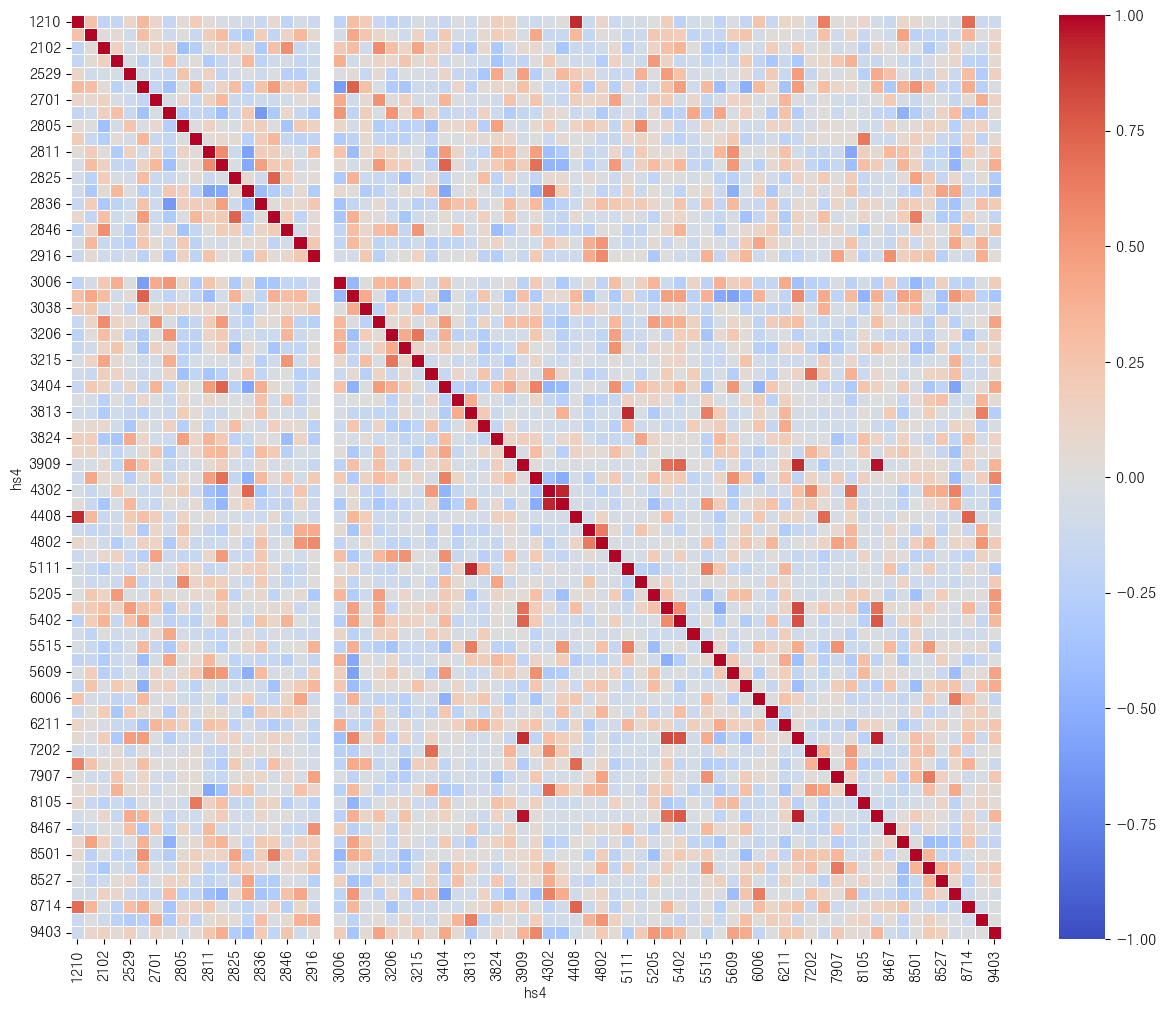

In [212]:
corr_matrix = rtn_data.corr()

plt.figure(figsize=(15, 12)) 

sns.heatmap(
    corr_matrix,       
    annot=False,
    cmap='coolwarm',   
    vmin=-1, vmax=1,
    linewidths=.5)
# 1 이하는 차가운색, 1 이상은 뜨거운 색
# 4408, 1210

plt.show()

In [229]:
corr_matrix

hs4,1210,2002,2102,2501,2529,2612,2701,2710,2805,2807,...,8461,8467,8479,8501,8505,8527,8708,8714,9022,9403
hs4,,,,,,,,,,,,,,,,,,,,,
1210,1.000000,0.266195,-0.189744,-0.168996,0.109076,0.321445,0.098504,-0.170283,0.034767,0.190105,...,-0.076323,-0.137360,0.091935,0.059054,-0.008449,-0.025276,-0.073898,0.699673,-0.129025,-0.113799
2002,0.266195,1.000000,0.016032,0.051445,-0.095109,0.294075,0.072650,-0.108941,0.005034,-0.140007,...,-0.023518,-0.096171,0.458654,-0.227797,-0.182458,-0.178189,-0.089934,0.344524,-0.020777,0.094322
2102,-0.189744,0.016032,1.000000,0.159073,-0.075612,0.024504,0.133328,0.149305,-0.386765,-0.260955,...,0.087026,-0.013298,0.136535,-0.028726,-0.318064,-0.103623,0.141933,-0.040718,-0.107320,0.147961
2501,-0.168996,0.051445,0.159073,1.000000,-0.050091,-0.218156,-0.045634,0.278669,-0.060918,0.016434,...,-0.149826,-0.030137,-0.119328,-0.195335,-0.068178,0.039226,0.088778,-0.216063,-0.219045,0.052196
2529,0.109076,-0.095109,-0.075612,-0.050091,1.000000,-0.081849,-0.117060,-0.146911,0.246486,-0.058775,...,0.411775,0.275235,-0.022561,-0.159959,-0.155593,0.089802,-0.129583,0.292096,-0.286910,0.162210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8527,-0.025276,-0.178189,-0.103623,0.039226,0.089802,-0.163534,-0.029719,0.135307,0.103815,-0.139327,...,0.029325,-0.048409,-0.381295,-0.154920,0.363604,1.000000,0.097038,-0.220584,0.035652,0.141522
8708,-0.073898,-0.089934,0.141933,0.088778,-0.129583,-0.186988,-0.163017,0.307757,-0.243171,-0.188704,...,-0.118681,-0.176844,-0.303826,-0.206478,0.241100,0.097038,1.000000,-0.123364,-0.022339,-0.058975
8714,0.699673,0.344524,-0.040718,-0.216063,0.292096,0.401988,0.059254,-0.344319,0.098271,0.144633,...,0.145916,0.149937,0.249964,-0.057407,-0.128575,-0.220584,-0.123364,1.000000,-0.093919,-0.018476


In [231]:
high_corr = []
for i, row in enumerate(corr_matrix[(corr_matrix > 0.5) & corr_matrix[(corr_matrix < 0.9)]].iterrows()):
    if row[1].any():
        print(( row[1][row[1].notna()].name, row[1][row[1].notna()].index.to_list()))
        high_corr.append((row[1][row[1].notna()].name, row[1][row[1].notna()].index.to_list()))
    

(1210, [7207, 8714])
(2102, [2846, 3102])
(2612, [3024, 8501])
(2701, [3102])
(2710, [3006, 3206])
(2805, [5119])
(2807, [8105])
(2811, [2814, 5609])
(2814, [2811, 3404, 4202, 5609])
(2825, [2841])
(2833, [4302])
(2841, [2825, 8501])
(2846, [2102, 3215])
(2847, [4802])
(2916, [4802, 8467])
(3006, [2710])
(3024, [2612, 7142, 8708])
(3102, [2102, 2701])
(3206, [2710, 3215])
(3207, [4810])
(3215, [2846, 3206])
(3307, [7202])
(3404, [2814, 4202, 4810, 5609])
(3813, [5515, 9022])
(3909, [5309, 5402])
(4202, [2814, 3404, 5609, 9403])
(4302, [2833, 7202, 8102, 8708])
(4403, [5515])
(4408, [7207, 8714])
(4601, [4802])
(4802, [2847, 2916, 4601, 9022])
(4810, [3207, 3404])
(5111, [5515])
(5119, [2805])
(5205, [9403])
(5309, [3909, 5402, 7142, 8461])
(5402, [3909, 5309, 7142, 8461])
(5515, [3813, 4403, 5111, 7907, 8505])
(5609, [2811, 2814, 3404, 4202])
(6006, [8708])
(7142, [3024, 5309, 5402])
(7202, [3307, 4302])
(7207, [1210, 4408])
(7907, [5515, 8505])
(8102, [4302])
(8105, [2807])
(8461, [53

In [252]:
dict_hight_corr = dict(high_corr)
dict_hight_corr[4408]

[7207, 8714]

In [250]:
pivot_monthly[4408]

date
2022-01-01    128180.0
2022-02-01     39362.0
2022-03-01         NaN
2022-04-01         NaN
2022-05-01     10107.0
2022-06-01         NaN
2022-07-01     60702.0
2022-08-01     41609.0
2022-09-01     37377.0
2022-10-01         NaN
2022-11-01    150088.0
2022-12-01     81672.0
2023-01-01     51074.0
2023-02-01         NaN
2023-03-01     15704.0
2023-04-01         NaN
2023-05-01     14979.0
2023-06-01      6152.0
2023-07-01         NaN
2023-08-01     40552.0
2023-09-01         NaN
2023-10-01    173333.0
2023-11-01    450648.0
2023-12-01    262239.0
2024-01-01    446435.0
2024-02-01     19098.0
2024-03-01     22006.0
2024-04-01     13799.0
2024-05-01     13419.0
2024-06-01       305.0
2024-07-01      5047.0
2024-08-01     21271.0
2024-09-01         NaN
2024-10-01     62535.0
2024-11-01       422.0
2024-12-01      3252.0
2025-01-01         NaN
2025-02-01         NaN
2025-03-01     23895.0
2025-04-01         NaN
2025-05-01      2553.0
2025-06-01    109377.0
2025-07-01     22722.0
Name: 

index = 29, item, item name: 4408 : [7207, 8714]


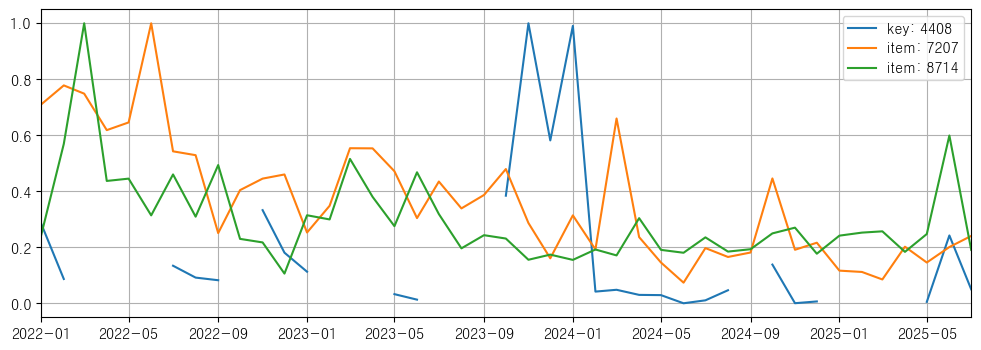

In [253]:
# sel_topN_hs4 = 14
# print(f'top{sel_topN_hs4}_hs4={topN_hs4[sel_topN_hs4-1]}, {len(dct_hs4_tmp_df[topN_hs4[sel_topN_hs4-1]])}개 아이템, {dct_hs4_tmp_df[topN_hs4[sel_topN_hs4-1]]}') # top1_hs4 : ['BSRMSVTC' 'DJBLNPNC' 'RCBZUSIM' 'SUOYXCHP' 'WQMVCOEM' 'ZKENOUDA']
#dct_hs4_tmp_df[topN_hs4[0]] #  for top-1

for i, (k, v) in enumerate(dict_hight_corr.items()):
    if k != 4408: continue
    print(f'index = {i+1}, item, item name: {k} : {v}')

    fig = plt.figure(figsize=(12,4))

    ax = plt.gca()
    # 상품별 월별 무역량(월 최대 3회 교역)
    ax.plot(pivot_monthly[k]/pivot_monthly[k].max(), label=f'key: {k}')
    
    
    for j, item in enumerate(v):
        ax.plot(pivot_monthly[item]/pivot_monthly[item].max(), label=f'item: {item}')
        
    
    ax.set_xlim([monthly['ym'].min(), monthly['ym'].max()])
    ax.legend()
    ax.grid()
    break